In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../utils/')
from radiomics_helper import read_as_grayscale, imdisp

import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision.transforms as transforms

from typing import Tuple
import os
import matplotlib.pyplot as plt

In [83]:
img_dir = '../data/mass_data/AIIMS_Delhi_Mass_Data/subtype_classification/images/'
labels_path = '../data/mass_data/AIIMS_Delhi_Mass_Data/subtype_classification/luminal_labels.csv'
IMG_SIZE = (256,256)

In [84]:
# split data

In [85]:
# 1. Assume you have a DataFrame or list with your metadata
# df columns: ['patient_id', 'image_id', 'image_path', 'label']
df = pd.read_csv(labels_path) 

# 2. Get unique patient IDs
unique_patients = df['Patient_id'].unique()

# 3. Split the PATIENTS, not the images
train_ids, test_ids = train_test_split(
    unique_patients, 
    test_size=0.2, 
    random_state=42
)

# 4. Filter the original dataframe based on these split IDs
train_df = df[df['Patient_id'].isin(train_ids)].reset_index(drop=True)
test_df = df[df['Patient_id'].isin(test_ids)].reset_index(drop=True)

print(f"Total Images: {len(df)}")
print(f"Train Images: {len(train_df)} (from {len(train_ids)} patients)")
print(f"Test Images:  {len(test_df)} (from {len(test_ids)} patients)")

Total Images: 200
Train Images: 161 (from 61 patients)
Test Images:  39 (from 16 patients)


In [86]:
# Create augmentations

In [106]:
bus_transform = A.Compose([
    # --- 1. GEOMETRIC ---
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    
    # FIXED: 'value' renamed to 'fill'
    #A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, fill=0, p=0.5),
    
    #A.OneOf([
    #    # FIXED: Removed 'alpha_affine' (use A.Affine separately if needed)
    #    A.ElasticTransform(alpha=120, sigma=120 * 0.05, p=0.5),
    #    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    #], p=0.3),

    # --- 2. PHYSICS & NOISE ---
    #A.MultiplicativeNoise(multiplier=(0.9, 1.1), elementwise=True, p=0.5),
    
    #A.OneOf([
    #    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    #    A.MedianBlur(blur_limit=3, p=0.5),
    #], p=0.2),

    # FIXED: Updated CoarseDropout arguments to use ranges and 'fill'
   # A.CoarseDropout(
   #     num_holes_range=(1, 2),       # Replaces min_holes, max_holes
   #     hole_height_range=(10, 30),   # Replaces min_height, max_height
   #     hole_width_range=(10, 30),    # Replaces min_width, max_width
   #     fill=0,                 # Note: Some versions use 'fill', others 'fill_value'
   #     p=0.2
   # ),

    # --- 3. DEVICE SETTINGS ---
    #A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    #A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    
    # --- 4. PREPROCESSING ---
    #A.Normalize(mean=(0.5), std=(0.5)),
    ToTensorV2()
])

In [107]:
test_df.groupby('Luminal').nunique()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Patient_id,Name,UHID,Date,IRCH,Gender,Age,...,RT,LAST FOLLOW UP,ALIVE,DEAD,mets within 3 years,Unnamed: 22,RISK_FACTOR,Unnamed: 24,Unnamed: 25,Image_file
Luminal,,,,,,,,,,,,,,,,,,,,,
0,13,6,6,6,6,6,6,6,1,6,...,2,6,1,1,2,1,0,0,0,13
1,26,10,10,10,10,10,10,10,1,10,...,2,10,1,1,4,0,0,0,0,26


In [108]:
train_df.groupby('Luminal').nunique()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Patient_id,Name,UHID,Date,IRCH,Gender,Age,...,RT,LAST FOLLOW UP,ALIVE,DEAD,mets within 3 years,Unnamed: 22,RISK_FACTOR,Unnamed: 24,Unnamed: 25,Image_file
Luminal,,,,,,,,,,,,,,,,,,,,,
0,43,20,20,20,20,20,18,20,1,14,...,3,18,1,1,7,1,1,1,1,43
1,118,41,41,41,41,41,38,41,2,24,...,2,39,4,1,12,0,0,0,0,118


In [109]:
#dataset
class LuminalDataset(Dataset):
    def __init__(self, image_dir: str, labels_df: pd.DataFrame, transform = None):
        self.image_dir = image_dir
        self.labels_df = labels_df

        self.transform = transform
        

    def __len__(self) -> int:
        return len(self.labels_df)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        row = self.labels_df.iloc[index]

        img_np = read_as_grayscale(self.image_dir + row['Image_file'])
        img_np = np.expand_dims(img_np, axis=2)

        if self.transform:
            augmented = self.transform(image=img_np)
            img = augmented['image']
        else:
            img = torch.from_numpy(img_np).float()

        label = torch.tensor(row['Luminal'].astype(float), dtype=torch.float)

        return img, label

In [110]:
#dataloader
train_dataset = LuminalDataset(img_dir, train_df, transform = bus_transform)

train_loader = DataLoader(train_dataset,
                          batch_size = 4,
                          num_workers = 0,
                          shuffle = True,
                          pin_memory = True)

image_sample, label_sample = next(iter(train_loader))

print(image_sample.shape, label_sample.shape)

torch.Size([4, 1, 256, 256]) torch.Size([4])


In [111]:
# visualise augmented data

In [112]:
def visualize_dataset_sample(dataset, idx=0):
    """
    Visualizes the Original (Raw) image vs. the Augmented (Transformed) image
    from the LuminalDataset.
    
    Args:
        dataset: Instance of LuminalDataset
        idx: Index of the item to visualize
    """
    
    # 1. Get the Raw Image Path (Bypassing __getitem__)
    # We access the internal dataframe to find the file path
    row = dataset.labels_df.iloc[idx]
    image_path = os.path.join(dataset.image_dir, row['Image_file'])
    
    # Read Original (Replicating your 'read_as_grayscale' logic)
    original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original_img is None:
        print(f"Error: Could not read file {image_path}")
        return

    # 2. Get the Augmented Version (Using __getitem__)
    # This calls your transform pipeline
    aug_tensor, label = dataset[idx]
    
    # 3. Convert Tensor back to Numpy for Plotting
    # Tensor is (C, H, W) -> Transpose to (H, W, C)
    aug_img = aug_tensor.permute(1, 2, 0).numpy()
    
    # 4. Denormalize for Visualization
    # If you used A.Normalize(mean=..., std=...), the pixel values are likely 
    # floats (e.g., -2.0 to 2.0). We need to scale them back to 0-1 range to see them clearly.
    # Simple Min-Max scaling is the safest way to visualize unknown normalization:
    aug_img_display = (aug_img - aug_img.min()) / (aug_img.max() - aug_img.min())
    
    # 5. Plot Side-by-Side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot Original
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title(f"Original (Index {idx})")
    axes[0].axis('off')
    
    # Plot Augmented
    # Note: We use 'gray' cmap, but if aug_img has 3 channels (RGB), imshow handles it automatically
    if aug_img_display.shape[2] == 1:
        axes[1].imshow(aug_img_display.squeeze(), cmap='gray')
    else:
        axes[1].imshow(aug_img_display)
        
    axes[1].set_title(f"Augmented (Label: {label.item()})")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

'''
# Example Usage:
# visualize_dataset_sample(train_dataset, idx=42)
```xlsx

### How to Diagnose Your Accuracy Drop (0.85 -> 0.73)

Run the function above on random indices. Look for these **red flags**:

1.  **The "Black Screen"**: If the **Augmented** image is almost entirely black or gray, your `CoarseDropout` is too aggressive, or `RandomBrightnessContrast` is pushing pixels to 0.
2.  **The "Ghost" Image**: If the augmented image looks like pure static/noise, your `MultiplicativeNoise` or `GaussNoise` is too high.
3.  **The "Wrong Way"**: If you see an ultrasound that is flipped upside down (fatty tissue at bottom, dense tissue at top), you have `VerticalFlip` enabled. This confuses the model because gravity/physics matters in ultrasound.
4.  **The "Zoomed In" Mess**: If `ElasticTransform` or `RandomResizedCrop` has zoomed in so much that the tumor is no longer visible (cropped out), your model is being trained on empty images labeled as "Tumor".
'''

'\n# Example Usage:\n# visualize_dataset_sample(train_dataset, idx=42)\n```xlsx\n\n### How to Diagnose Your Accuracy Drop (0.85 -> 0.73)\n\nRun the function above on random indices. Look for these **red flags**:\n\n1.  **The "Black Screen"**: If the **Augmented** image is almost entirely black or gray, your `CoarseDropout` is too aggressive, or `RandomBrightnessContrast` is pushing pixels to 0.\n2.  **The "Ghost" Image**: If the augmented image looks like pure static/noise, your `MultiplicativeNoise` or `GaussNoise` is too high.\n3.  **The "Wrong Way"**: If you see an ultrasound that is flipped upside down (fatty tissue at bottom, dense tissue at top), you have `VerticalFlip` enabled. This confuses the model because gravity/physics matters in ultrasound.\n4.  **The "Zoomed In" Mess**: If `ElasticTransform` or `RandomResizedCrop` has zoomed in so much that the tumor is no longer visible (cropped out), your model is being trained on empty images labeled as "Tumor".\n'

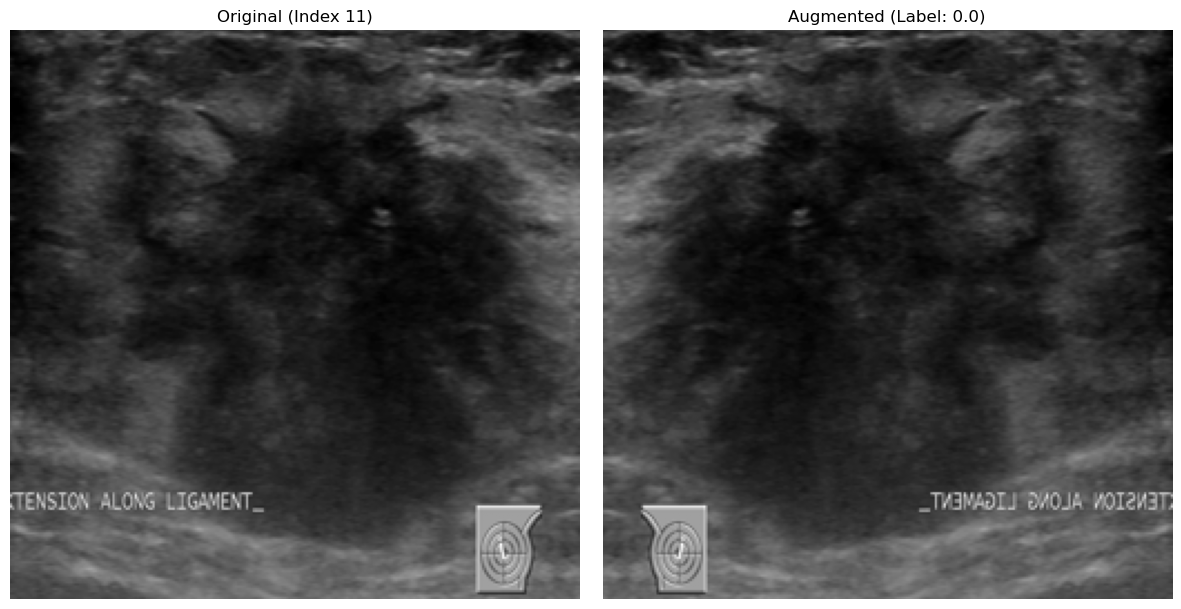

In [113]:
visualize_dataset_sample(train_dataset, idx=11)

In [114]:
#model
class BinaryClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 32*64*64, out_features = 128),
            nn.Linear(in_features = 128, out_features = 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x
        

In [115]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        output = model(images)

        loss = criterion(output.view(-1), labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        probs = torch.sigmoid(output.view(-1))
        preds = (probs > 0.5).float()
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    acc = correct_predictions / total_samples

    return avg_loss, acc
        

In [116]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [117]:
model = BinaryClassification().to(device)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [118]:
for epoch in range(20):
    l, a = train_one_epoch(model, train_loader, loss, optimizer, device)
    print(epoch, l, a)

0 1.9329208680970158 0.6086956521739131
1 0.6080261468887329 0.7329192546583851
2 0.5695648473210451 0.7329192546583851
3 0.5481457346823158 0.7453416149068323
4 0.5387126109222087 0.782608695652174
5 0.5237005640093874 0.7950310559006211
6 0.4852264878771654 0.8074534161490683
7 0.5277358050480848 0.7950310559006211
8 0.3748587498941073 0.8571428571428571
9 0.3933071913879092 0.8509316770186336
10 0.7201374013158535 0.8074534161490683
11 0.3504633536880336 0.8695652173913043
12 0.3213654463974441 0.8757763975155279
13 0.2882424871119239 0.9006211180124224
14 0.2432737426786888 0.9254658385093167
15 0.1988633466208717 0.9254658385093167
16 0.1573626205506848 0.9503105590062112
17 0.3251083870759098 0.8757763975155279
18 0.248522232400208 0.9130434782608695
19 0.1866396706233301 0.9192546583850931


In [119]:
def evaluate(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs.view(-1), labels)

            running_loss += loss.item()

            probs = torch.sigmoid(outputs.view(-1))
            preds = (probs > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    acc = correct_predictions / total_samples

    return avg_loss, acc

In [120]:
test_dataset = LuminalDataset(img_dir, test_df)

test_loader = DataLoader(train_dataset,
                          batch_size = 4,
                          num_workers = 0,
                          shuffle = True,
                          pin_memory = True)

image_sample, label_sample = next(iter(train_loader))

In [121]:
l, a = evaluate(model, loss, test_loader, device)
print(l, a)

0.16586139193940452 0.9254658385093167
